# Figure 1 Supplement:  Big In Vivo Clones.

We stimulated single cells as in P1902 and 3128 etc… in vitro and grew large clonal populations.  Here the clones P1 and P2 and P3 are unrelated expansions where we were able to sort large numbers of cells for scRNAseq.  We also have some in vivo cells.

The data were generated with smart-seq3 which is a more sensitive version of the old method we used in all other datasets we have (besides MR - that is 10x kits)

In [1]:
import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import statsmodels.api as sm

from IPython.display import display # Pretty display of data frames.

# Import various functions for stats.
import scipy.stats as ss
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew, zscore # For detecting bimodality
import scipy.cluster.hierarchy as sch # For hierarchical clustering.

from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA
import umap

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import anndata
# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
file_prefix = '../Data/Processed/Big_Invitro_SS3'
file_suffix = '.loom'  

In [3]:

mm = 1 / 25.4 # Millimeters

plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))

font

'/System/Library/Fonts/Helvetica.ttc'

In [4]:
def setfontsize():
    SMALL_SIZE = 6
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 6

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

In [5]:
def desetfontsize():
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

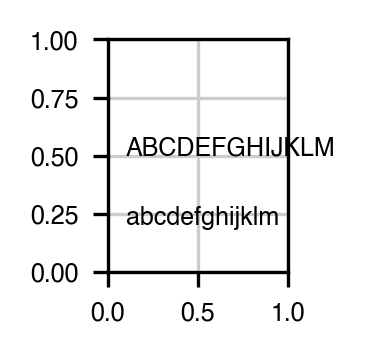

In [7]:
figsize = (30*mm,30*mm)
setfontsize()
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
ax.text(0.1,0.5,'ABCDEFGHIJKLM')
ax.text(0.1,0.2, 'abcdefghijklm')

set_size(fig, figsize)
plt.savefig('SuppPanels/TestSquare.pdf', bbox_inches='tight')
plt.show()

# Loading data


In [8]:
datasets = ['readexon', 'readinex', 'umiexon', 'umiinex']
adata = {}
for ds in datasets:
    adata[ds] = anndata.read_loom(file_prefix+'_'+ds+file_suffix)
    adata[ds].var_names = adata[ds].var['gene_name']
    adata[ds].obs_names = adata[ds].obs['obs_names']

In [9]:
for ds in datasets:
    print('Data for {} loaded'.format(ds))
    print(adata[ds])
    print('------------------------------------')

Data for readexon loaded
AnnData object with n_obs × n_vars = 623 × 9715
    obs: 'FCS', 'SSC', 'clone_id', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'total_counts', 'total_counts_mt'
    var: 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells_by_counts', 'pct_dropout_by_counts', 'total_counts', 'transcript_length', 'variances', 'variances_norm'
------------------------------------
Data for readinex loaded
AnnData object with n_obs × n_vars = 632 × 10774
    obs: 'FCS', 'SSC', 'clone_id', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'total_counts', 'total_counts_mt'
    var: 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_coun

# Clustering experiments on UMI data

## PCA plots, with SELL and GNLY.

... storing 'clone_id' as categorical


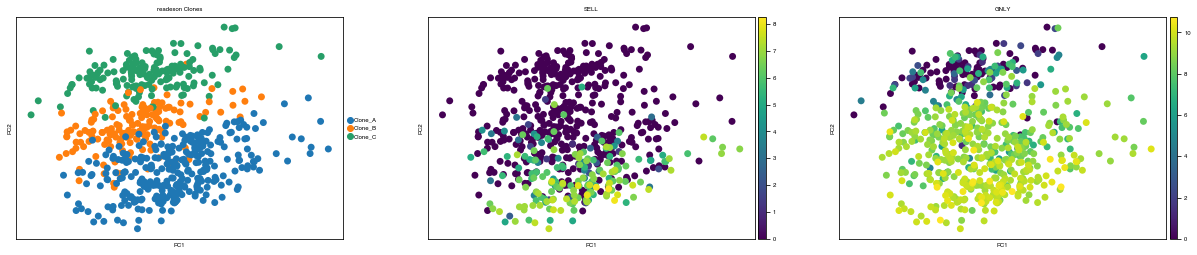

... storing 'clone_id' as categorical


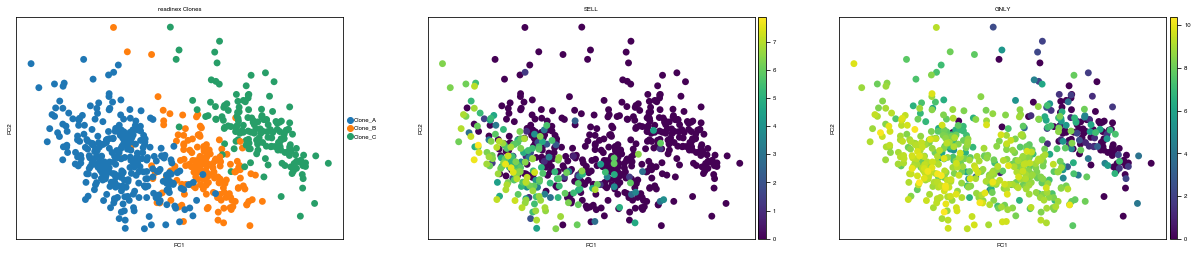

... storing 'clone_id' as categorical


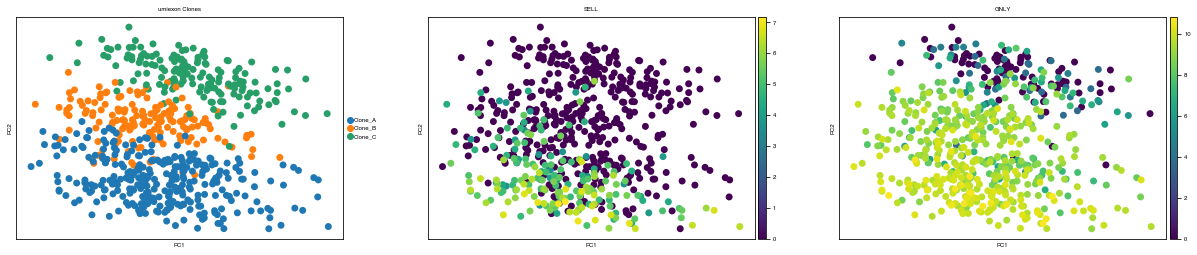

... storing 'clone_id' as categorical


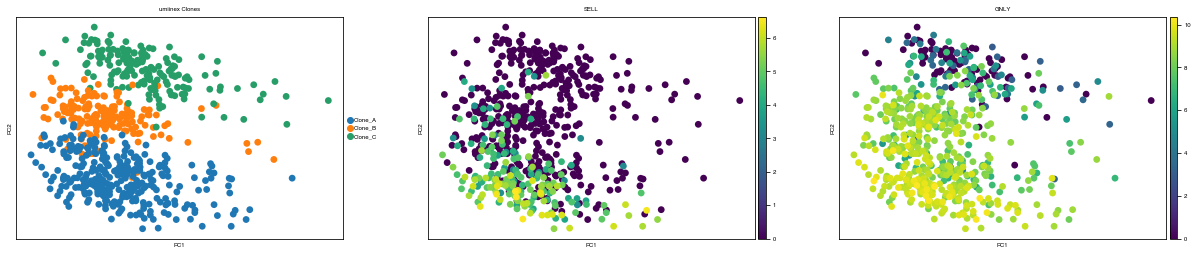

In [10]:
for j,ds in enumerate(datasets):
    sc.tl.pca(adata[ds], svd_solver='arpack', use_highly_variable=False)
    sc.pl.pca(adata[ds], color=['clone_id','SELL','GNLY'], title=[ds+' Clones', 'SELL', 'GNLY'])

## UMAP plots, with GZMH and CCR7.  And MT-count just in case, for quality control.

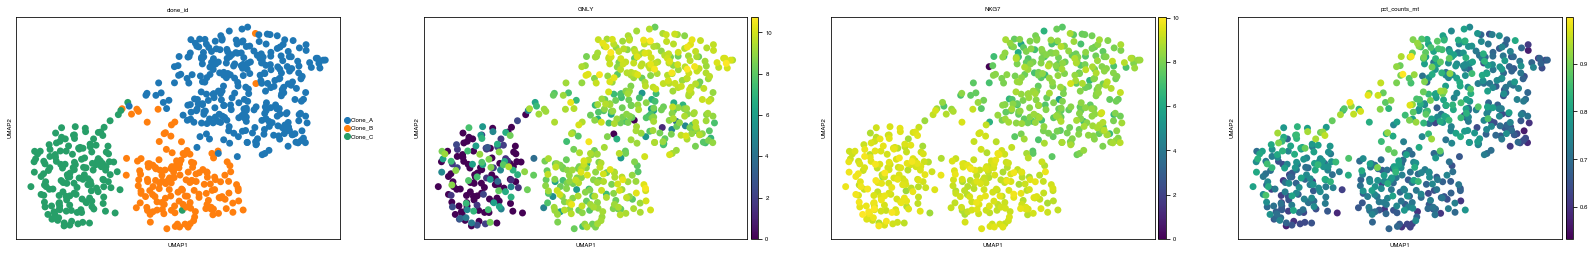

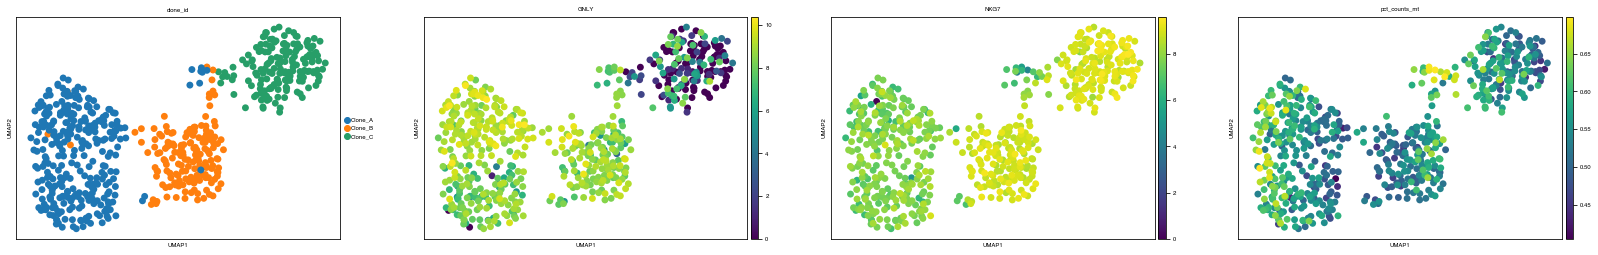

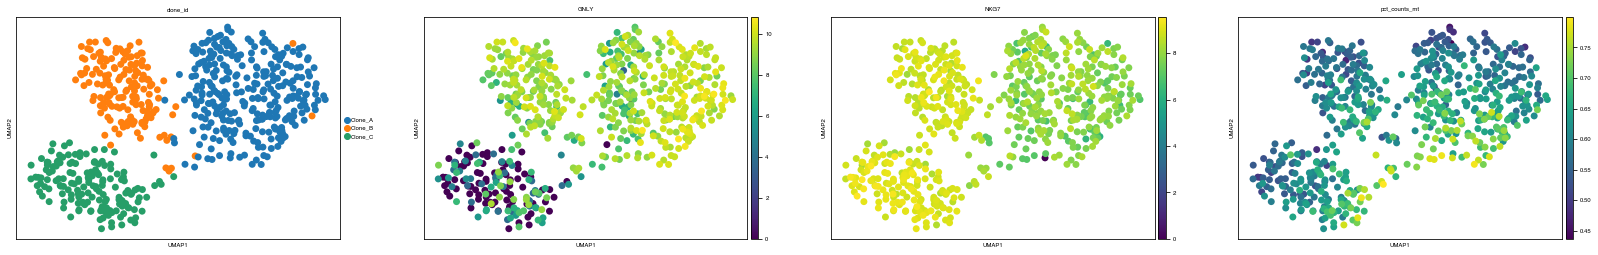

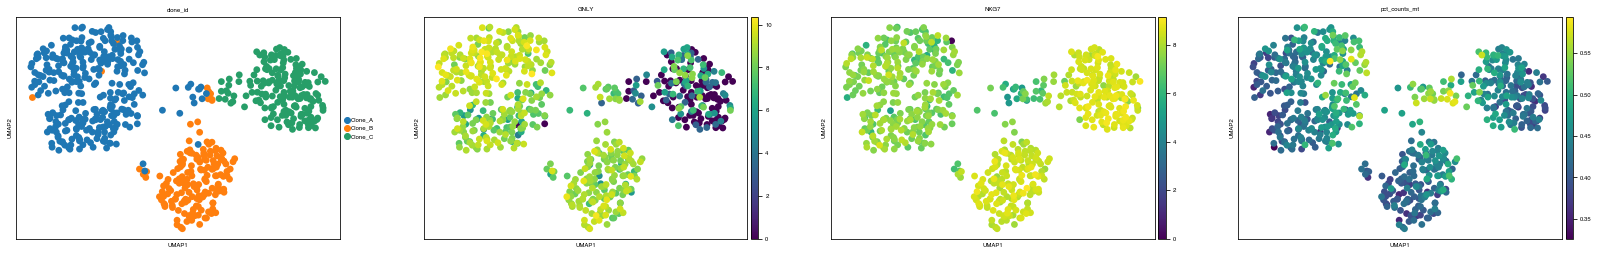

In [11]:
for ds in datasets:
    sc.pp.neighbors(adata[ds], n_neighbors=10, n_pcs=20)
    sc.tl.umap(adata[ds])
    sc.pl.umap(adata[ds], color=['clone_id', 'GNLY', 'NKG7', 'pct_counts_mt'])
    #, title=[ds+' Clones','GZMH', 'SELL', 'MT-count'])

# Panel:  UMAP clusters, with number of genes and reads.

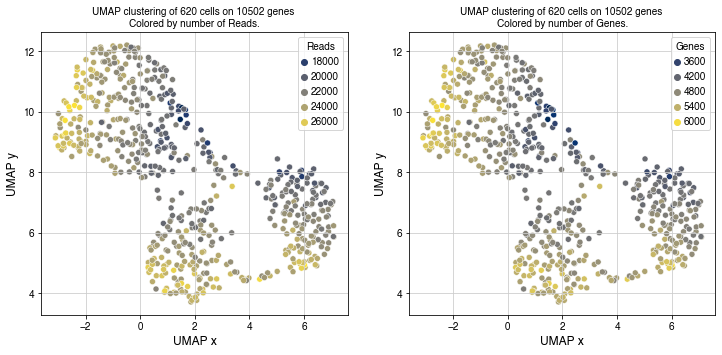

In [12]:
n_components = 20
n_neighbors = 10
min_dist = 0.25
desetfontsize()
fig, ax = plt.subplots(1,2, figsize=(12,5))

X = adata['umiexon'].to_df()
y = adata['umiexon'].obs.clone_id
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                        random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = ['Clone '+cl for cl in y.values]
cl_df['Reads'] = adata['umiinex'].obs.n_counts
cl_df['Genes'] = adata['umiinex'].obs.n_genes

for j,what in enumerate(['Reads','Genes']):
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue=what, palette='cividis', data = cl_df, ax=ax[j])
    #if j == 0:
    #    g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)

    ax[j].set_title('UMAP clustering of {} cells on {} genes \n' 
                    'Colored by number of {}.'.format(X.shape[0], X.shape[1], what))

plt.show()

## Panel:  TPM vs UMI Clustering

In [13]:
X_TPM = adata['readexon'].to_df().copy()
TPM_expressed = (X_TPM.quantile(0.95) > 0.0)
TPM_expressed = TPM_expressed[TPM_expressed].index
X_TPM = X_TPM[TPM_expressed]

X_UMI = adata['umiexon'].to_df().copy()

cells = [cell for cell in X_TPM.index if cell in X_UMI.index]
X_TPM = X_TPM.loc[cells]
X_UMI = X_UMI.loc[cells]

if set(X_TPM.index) != set(X_UMI.index):
    print('Different indices!')
    
y = adata['readexon'].obs.clone_id.loc[cells] # Same indices.

We only keep the genes which are expressed by 5% of cells in the TPM data.

In [14]:
X_UMI.shape

(616, 10502)

In [15]:
X_TPM.shape

(616, 9715)

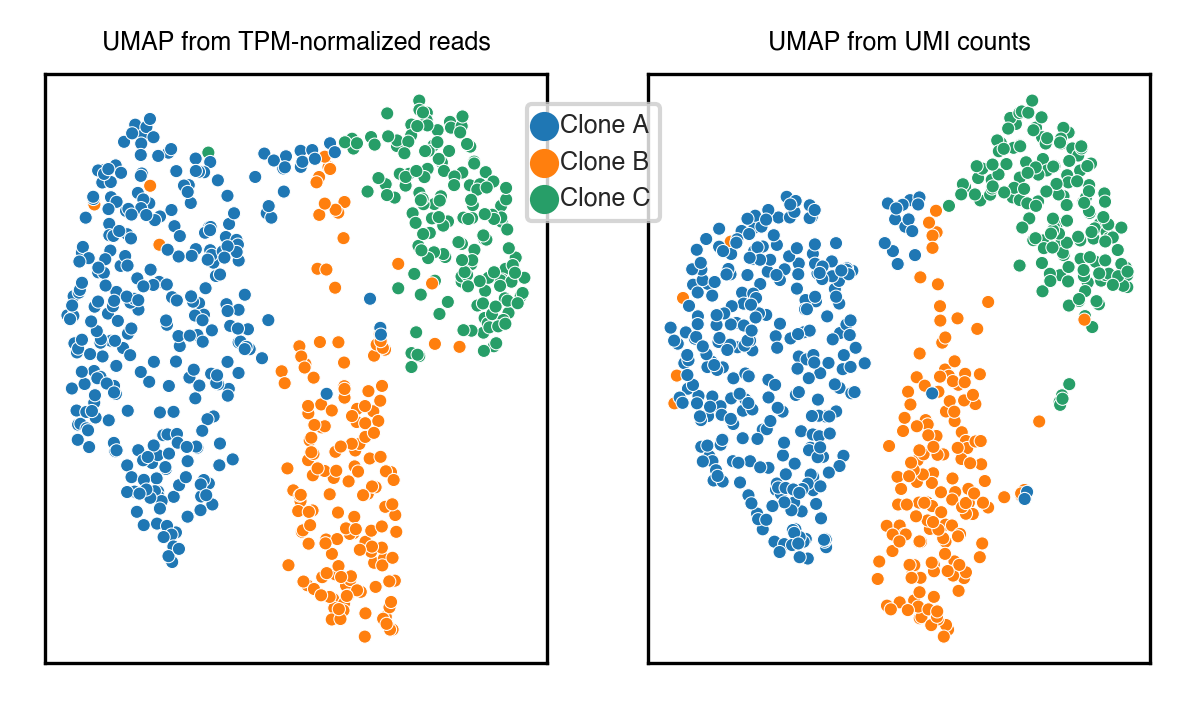

In [16]:
n_components = 20
n_neighbors = 10
min_dist = 0.25

figsize=(100*mm,60*mm)
fig, ax = plt.subplots(1,2, figsize=(100*mm,60*mm), dpi=300)


sns.set_style('whitegrid')
setfontsize()

clone_order = ['Clone A', 'Clone B', 'Clone C']

for j,X in enumerate([X_TPM, X_UMI]):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
    X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

    cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
    cl_df['Clone'] = ['Clone '+cl.split('_')[1] for cl in y.values]
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', s=10, 
                        hue_order = clone_order, data = cl_df, ax=ax[j])
    if j == 0:
        axtitle = 'UMAP from TPM-normalized reads'.format(X.shape[0], X.shape[1])
        g.legend().remove()
    if j == 1:
        axtitle = 'UMAP from UMI counts'.format(X.shape[0], X.shape[1])
        g.legend(loc='center right', bbox_to_anchor=(0.05, 0.85), ncol=1)
    ax[j].set_title(axtitle)
    ax[j].set_xlabel('')
    ax[j].set_ylabel('')
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    
set_size(fig, figsize)
plt.savefig('SuppPanels/TPM_UMI_Cluster_biginvitro.pdf', bbox_inches='tight')
plt.show()

## TPM (reads) vs UMI gene significance

In [17]:
def ANOVA_p(X,y):
    args = [X[y == k] for k in np.unique(y)]
    pvals = f_oneway(*args)[1] # Use f_oneway for high precision.
    return pd.Series(pvals, index=X.columns, name='pval') # Built-in ANOVA F from scikit.

gene_names = [gene for gene in X_TPM.columns if gene in X_UMI.columns]

Fp_comp_df = pd.DataFrame(index=gene_names)
# Fp_comp_df['gene_name'] = Fp_comp_df.index
Fp_comp_df['TPM_p'] = ANOVA_p(X_TPM,y).loc[gene_names]
Fp_comp_df['UMI_p'] = ANOVA_p(X_UMI,y).loc[gene_names]
Fp_comp_df['TPM_logp'] = -np.log10(Fp_comp_df['TPM_p'])
Fp_comp_df['UMI_logp'] = -np.log10(Fp_comp_df['UMI_p'])
Fp_comp_df = Fp_comp_df.sort_values('TPM_p')
Fp_comp_df.head() # Display the top 5 genes, according to the A1 split.

Fp_comp_df.to_csv('SuppPanels/TPM_UMI_clonal_pvals_biginvitro.csv')

In [18]:
Fp_comp_df[:10]

,TPM_p,UMI_p,TPM_logp,UMI_logp
GNLY,1.193374e-144,1.817085e-139,143.923223,138.740625
NKG7,3.001898e-112,7.211737e-98,111.522604,97.141960
ITGAD,6.728992e-102,5.585715e-105,101.172050,104.252921
KLRD1,3.374918e-90,2.673679e-94,89.471737,93.572891
FTH1,1.441581e-86,2.613037e-70,85.841161,69.582854
FCER1G,5.660096e-86,5.703402e-82,85.247176,81.243866
CD84,5.109078e-76,1.586025e-84,75.291657,83.799690
LYAR,5.843088e-68,1.306724e-75,67.233358,74.883816
BMS1P5,8.410256e-59,4.735676e-47,58.075191,46.324618
CD74,3.473234e-55,2.483079e-52,54.459266,51.605009


In [19]:
from adjustText import adjust_text

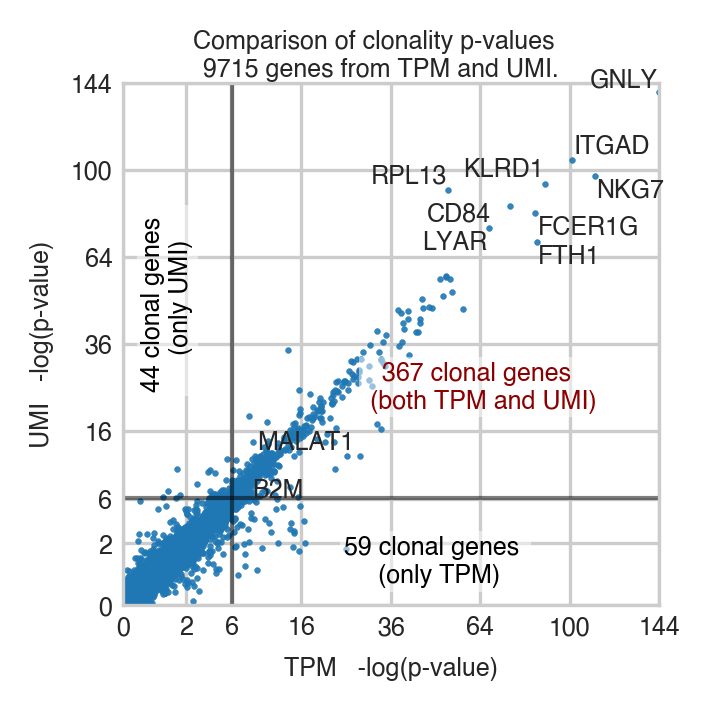

In [20]:
figsize=(60*mm,60*mm)
fig, ax = plt.subplots(1,1, figsize=figsize, dpi=300)


sns.set_style('whitegrid')
setfontsize()


#TnotU_genes = Fp_comp_df[(Fp_comp_df['TPM_logp'] > 6) & (Fp_comp_df['UMI_logp'] < 2)].index
#UnotT_genes = Fp_comp_df[(Fp_comp_df['UMI_logp'] > 6) & (Fp_comp_df['TPM_logp'] < 2)].index
#odd_genes = list(set(TnotU_genes) | set(UnotT_genes))

plot_df = pd.DataFrame(index = Fp_comp_df.index)
plot_df['Clonal sig. ($-\log(p)$) from TPM'] = np.sqrt(Fp_comp_df['TPM_logp'])
plot_df['Clonal sig. ($-\log(p)$) from UMI'] = np.sqrt(Fp_comp_df['UMI_logp'])
# plot_df['Outliers'] = plot_df.index.isin(odd_genes)
sns.scatterplot(x='Clonal sig. ($-\log(p)$) from TPM',
                y='Clonal sig. ($-\log(p)$) from UMI', 
                data=plot_df, ax=ax, 
                edgecolor=None, alpha=0.9, s=2) 
                #hue='Outliers', legend=None)

ann_genes = list(Fp_comp_df[(Fp_comp_df['TPM_logp'] > 60) | (Fp_comp_df['UMI_logp'] > 60)].index)
ann_genes += ['B2M', 'MALAT1']
#for gene in ann_genes:
    #x_gene = plot_df.loc[gene,'Clonal sig. ($-\log(p)$) from TPM']
    #y_gene = plot_df.loc[gene, 'Clonal sig. ($-\log(p)$) from UMI']
    #ax.annotate(gene, (x_gene,y_gene))
texts = [plt.text(plot_df.loc[gene,'Clonal sig. ($-\log(p)$) from TPM'], 
                  plot_df.loc[gene, 'Clonal sig. ($-\log(p)$) from UMI'],
                  gene, ha='center', va='center') 
         for gene in ann_genes]
adjust_text(texts, expand_text=(1.02, 1.00))
    
bbox = dict(facecolor='white', edgecolor=None, linewidth=0, alpha=0.5, pad=1.0)

G_count = len(Fp_comp_df[(Fp_comp_df['TPM_logp'] >= 6) & (Fp_comp_df['UMI_logp'] < 6)].index)
ax.text(7, 1 , '{} clonal genes \n (only TPM)'.format(G_count),
        horizontalalignment='center',
        verticalalignment='center', color = 'k', 
        bbox=bbox)

G_count = len(Fp_comp_df[(Fp_comp_df['TPM_logp'] < 6) & (Fp_comp_df['UMI_logp'] >= 6)].index)
ax.text(1,7, '{} clonal genes \n (only UMI)'.format(G_count),
        horizontalalignment='center',
        verticalalignment='center', color = 'k', rotation=90,
        bbox=bbox)

G_count = len(Fp_comp_df[(Fp_comp_df['TPM_logp'] >= 6) & (Fp_comp_df['UMI_logp'] >= 6)].index)
ax.text(8,5, '{} clonal genes \n (both TPM and UMI)'.format(G_count),
        horizontalalignment='center',
        verticalalignment='center', color = 'darkred',
        bbox=bbox)

tlist = [0,1.414,2.44,4,6,8,10,12]
ttlist = [0,2,6,16,36,64,100,144]
ax.set_xticks(tlist)
ax.set_yticks(tlist)
ax.set_xticklabels(ttlist)
ax.set_yticklabels(ttlist)

ax.set_xlim(0,12)
ax.set_ylim(0,12)

ax.axhline(np.sqrt(6), color='k', linewidth=1, alpha=0.5)
ax.axvline(np.sqrt(6), color='k', linewidth=1, alpha=0.5)

ax.set_xlabel('TPM   -log(p-value)')
ax.set_ylabel('UMI   -log(p-value)')
ax.tick_params(axis='both', pad=-1)
plt.suptitle('Comparison of clonality p-values \n {} genes from TPM and UMI.'.format(len(plot_df)), x=0.55, y=0.99)

set_size(fig, figsize)
plt.savefig('SuppPanels/TPM_UMI_Cluster_biginvitro.pdf', bbox_inches='tight')
plt.show()

In [21]:
def TPMUMI_comp(gene):
    desetfontsize()
    TPMp = Fp_comp_df.loc[gene,'TPM_logp']
    UMIp = Fp_comp_df.loc[gene,'UMI_logp']

    fig,ax = plt.subplots(1,2,figsize=(10,5))

    sns.violinplot(x=y, y=X_TPM[gene], cut=0, ax=ax[0], inner='stick')
    sns.violinplot(x=y, y=X_UMI[gene], cut=0, ax=ax[1], inner='stick')

    ax[0].set_ylabel('{} $log_2(TPM)$'.format(gene))
    ax[1].set_ylabel('{} $log_2(UMI)$'.format(gene))

    ax[0].set_title('TPM: -log(p) = {:1.5f}'.format(10**(-TPMp)))
    ax[1].set_title('UMI: -log(p) = {:1.5f}'.format(10**(-UMIp)))
    
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')

    plt.suptitle('Compairson of TPM and UMI distributions')
    plt.show()


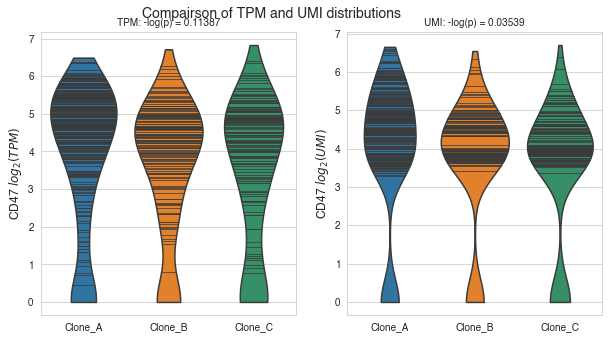

In [22]:
TPMUMI_comp('CD47')

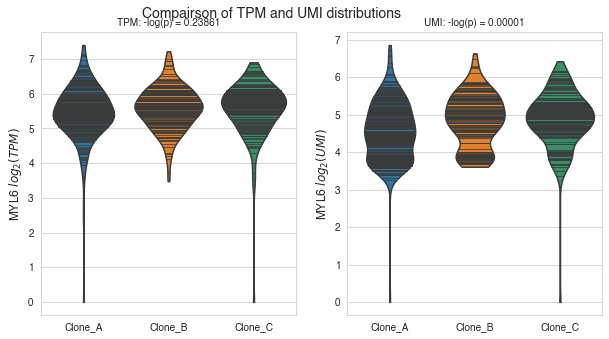

In [23]:
TPMUMI_comp('MYL6')

# Machine learning

Now we look at the accuracy of an SVM classifier on these three clones.  We split the large clone into two pieces , and randomly downsample the others to match populations.  The result is two splits of the data into three equal-size clones.

First is a generic downsampling function.

In [24]:
def downsample(X,y):
    ds = y.value_counts().min()
    y_cats = y.unique()
    X_list = []
    y_list = []
    for yc in y_cats:
        y_yc = y[y==yc].sample(n=ds)
        y_list.append(y_yc)
        X_list.append(X.loc[y_yc.index])
    return pd.concat(X_list), pd.concat(y_list)

Now we create our downsampled expression matrices and clone ids.  We use the UMI data from exons only in what follows.

In [25]:
X = adata['umiexon'].to_df().copy()
X = X[X.columns[X.sum() > 5]] # Ignore all genes with total UMI count <= 5 among all cells.

y = adata['umiexon'].obs.clone_id.sort_values()
X = X.reindex(y.index)

y_A = y[y == 'Clone_A']

y_A1 = y_A.sample(frac=0.5)
y_A2 = y_A.drop(y_A1.index)

y_1 = pd.concat([y_A1, y[y =='Clone_B'], y[y =='Clone_C']]) 
y_2 = pd.concat([y_A2, y[y =='Clone_B'], y[y =='Clone_C']])

X_1 = X.loc[y_1.index]
X_2 = X.loc[y_2.index]

X_1, y_1 = downsample(X_1,y_1)
X_2, y_2 = downsample(X_2,y_2)
display(y_1.value_counts())
display(y_2.value_counts())

Clone_A    149
Clone_B    149
Clone_C    149
Name: clone_id, dtype: int64

Clone_A    149
Clone_B    149
Clone_C    149
Name: clone_id, dtype: int64

In [26]:
y.value_counts()

Clone_A    298
Clone_B    162
Clone_C    160
Name: clone_id, dtype: int64

In [27]:
len(y)

620

Now we introduce our SVM pipeline, and a general-purpose function for cross-validation and visualization of accuracy.

In [28]:
SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=100), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000))

In [29]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    desetfontsize()
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with {0:}-fold cross-validation. \n"
                 "Best score {1:2.1%} with parameters \n"
                 "{2} ".format(gs.cv, gs.best_score_, gs.best_params_))

Now we run the SVM pipeline... twice.  Once for each half of the A-clones.

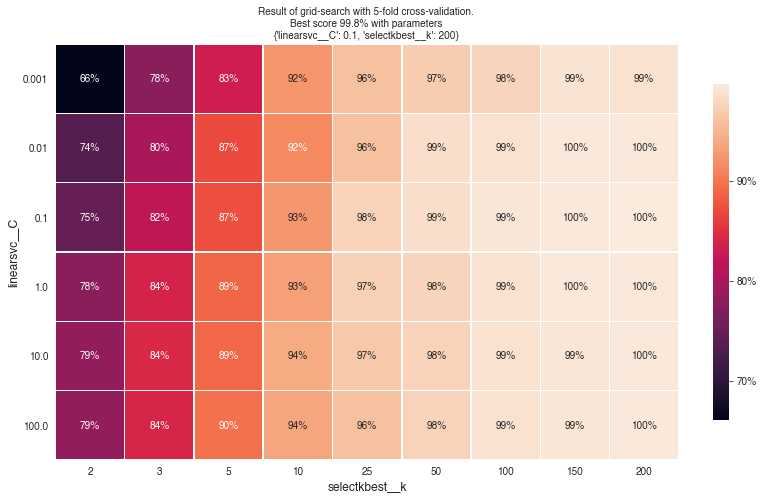

In [30]:
# DANGER DANGER:  The following suppresses all warnings from Python.
# Otherwise, you'll probably get a bunch of convergence warnings...
# Alternatively, increase the number of iterations in the SVM.

import warnings
warnings.filterwarnings('ignore') # Ignore warnings.

param_grid = dict(linearsvc__C=[0.001, 0.01, 0.1, 1.0, 10, 100],
                  selectkbest__k = [2,3,5,10,25,50,100,150,200]
                 )

grid_search = GridSearchCV(SVMpipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search.fit(X_1,y_1)

CV_map(grid_search)

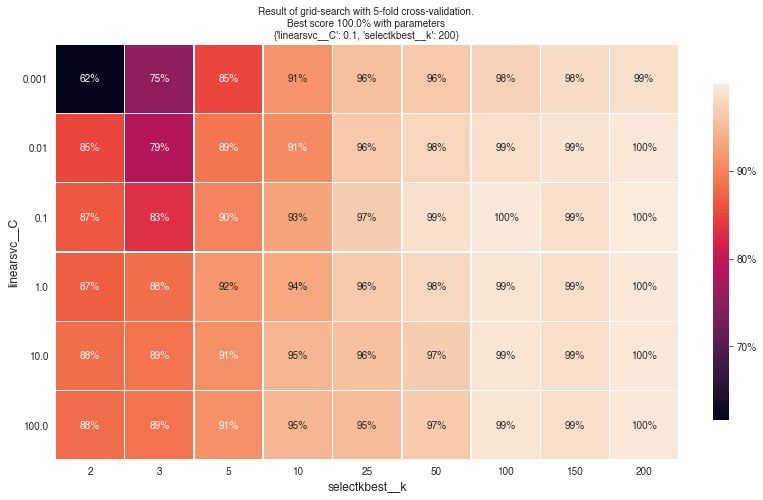

In [31]:
# DANGER DANGER:  The following suppresses all warnings from Python.
# Otherwise, you'll probably get a bunch of convergence warnings...
# Alternatively, increase the number of iterations in the SVM.

import warnings
warnings.filterwarnings('ignore') # Ignore warnings.

param_grid = dict(linearsvc__C=[0.001, 0.01, 0.1, 1.0, 10, 100],
                  selectkbest__k = [2,3,5,10,25,50,100,150,200]
                 )

grid_search = GridSearchCV(SVMpipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search.fit(X_2,y_2)

CV_map(grid_search)

# SVM accuracy

In [30]:
X = adata['umiexon'].to_df().copy()
X = X[X.columns[X.sum() > 5]] # Ignore all genes with total UMI count <= 5 among all cells.

y = adata['umiexon'].obs.clone_id.sort_values()
X = X.reindex(y.index)

In [31]:
yshuff = pd.Series(np.random.permutation(y.values), index=y.index, name='clone_id')

In [34]:
k_testlist = list(range(1,10)) + list(range(10,20,2)) + list(range(20,40,5)) + list(range(40,90,10)) + list(range(100,200,25)) + list(range(200,400,50)) + list(range(400,801,100))
SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=0.1, max_iter=2000)) ])

param_grid = dict(skb__k = k_testlist, svm__C = [0.1])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('skb', SelectKBest(k=110)),
                                       ('svm',
                                        LinearSVC(C=0.1, max_iter=2000,
                                                  random_state=0))]),
             param_grid={'skb__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16,
                                    18, 20, 25, 30, 35, 40, 50, 60, 70, 80, 100,
                                    125, 150, 175, 200, 250, 300, ...],
                         'svm__C': [0.1]})

In [35]:
SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=0.1, max_iter=2000)) ])

param_grid = dict(skb__k = k_testlist, svm__C = [0.1])

grid_search_shuff = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search_shuff.fit(X,yshuff)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('skb', SelectKBest(k=110)),
                                       ('svm',
                                        LinearSVC(C=0.1, max_iter=2000,
                                                  random_state=0))]),
             param_grid={'skb__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16,
                                    18, 20, 25, 30, 35, 40, 50, 60, 70, 80, 100,
                                    125, 150, 175, 200, 250, 300, ...],
                         'svm__C': [0.1]})

In [36]:
CV_df = pd.DataFrame()
for split in range(5):
    split_string = 'split'+str(split)+'_test_score'
    CV_df[split] = grid_search.cv_results_[split_string]
CV_df['Number of genes'] = grid_search.cv_results_['param_skb__k'].data
CV_df['Clonal prediction accuracy'] = grid_search.cv_results_['mean_test_score']

CV_df.head()
CV_melt = pd.melt(CV_df, id_vars='Number of genes', value_vars=[0,1,2,3,4], value_name='Clonal prediction accuracy')
CV_shuff = pd.DataFrame()
CV_shuff['Number of genes'] = grid_search_shuff.cv_results_['param_skb__k'].data
CV_shuff['Clonal prediction accuracy'] = grid_search_shuff.cv_results_['mean_test_score']

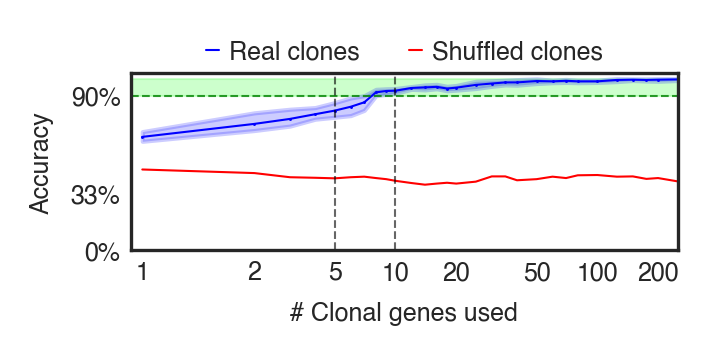

In [83]:
#fig,ax = plt.subplots(figsize = (20,6))
figsize = (60*mm, 30*mm)
f, ax = plt.subplots(figsize=figsize, dpi=300)


sns.set_style("white")
setfontsize()

sns.lineplot(x = 'Number of genes', y = 'Clonal prediction accuracy', data=CV_melt,
            color='blue', label='Real clones', linewidth=0.5)

sns.scatterplot(x = 'Number of genes', y = 'Clonal prediction accuracy', data=CV_df, 
                color='blue', s=0.5, linewidth=0)

sns.lineplot(x = 'Number of genes', y = 'Clonal prediction accuracy', data=CV_shuff, 
             color='red', label='Shuffled clones', linewidth=0.5)

ax.set_xscale('symlog')
#ax.set_yticks(np.linspace(0.0,1.0,5))

#ax.yaxis.set_label_position("right")
ax.set_yticks([0,0.33,0.9])
vals = ax.get_yticks()

ax.set_yticklabels(['{:1.0%}'.format(y) for y in vals])
ax.set_ylabel('Accuracy')
ax.set_xlabel('# Clonal genes used')

ax.set_xticks([1,2,5,10,20,50,100,200])
vals = ax.get_xticks()
ax.set_xticklabels(['{}'.format(x) for x in vals])
ax.set_xlim(0.9,250)

ax.tick_params(axis='both', which='major', pad=-1)


ax.add_patch(plt.Rectangle((0,0.9), 800, 0.1, zorder=0, color=(0.5,1,0.5,0.4), linewidth=0.5))
#ax.text(1.1, 0.91, '90%-100%', color='green', ha='left')

ax.axhline(0.9,linestyle='--', linewidth=0.5, color='green', alpha=0.8)

ax.axvline(5, linestyle='--', linewidth=0.5, color='k', alpha=0.6) # vertical lines
ax.axvline(10, linestyle='--', linewidth=0.5, color='k', alpha=0.6) # vertical lines

plt.legend(bbox_to_anchor=(0.5, 1), loc='lower center', borderaxespad=0., ncol=2, frameon=False)

#plt.suptitle('Accuracy of clonal prediction by linear SVM.', y=1.1)# \n'
         #    'SVM penality parameter fixed at C = 0.1. \n'
         #   'Linear SVM restricted to {} -- {} most significant genes'.format(vals[0], vals[-1]), y=1.0)

set_size(f, figsize)
plt.savefig('Panels/SVM_graph_biginvitro.pdf', bbox_inches='tight')
    
plt.show()


# Differential expression

Here we use the ANOVA F test to measure the differential expression of genes between the three clones.  As before, we run this twice (splitting Clone A) to improve robustness of our DE gene lists.

In [35]:
def ANOVA_p(X,y):
    args = [X[y == k] for k in np.unique(y)]
    pvals = f_oneway(*args)[1] # Use f_oneway for high precision.
    return pd.Series(pvals, index=X.columns, name='pval') # Built-in ANOVA F from scikit.

gene_names = [gene for gene in X_TPM.columns if gene in X_UMI.columns]

Fp_UMI = ANOVA_p(X,y)
Fp_1 = ANOVA_p(X_1,y_1)
Fp_2 = ANOVA_p(X_2,y_2)

Fp = pd.DataFrame({'gene_name':X_1.columns, 'A':Fp_UMI, 'A1':Fp_1, 'A2':Fp_2}, index=Fp_1.index)
Fp = Fp.sort_values('A')
Fp.head() # Display the top 5 genes, according to the A1 split.

,gene_name,A,A1,A2
gene_name,,,,
GNLY,GNLY,3.767955e-140,8.022833e-98,1.628599e-101
ITGAD,ITGAD,6.841299e-107,3.358895e-70,3.897606e-71
NKG7,NKG7,2.218825e-98,5.464388e-63,1.209234e-97
KLRD1,KLRD1,1.187791e-95,6.037506e-68,3.506917e-71
RPL13,RPL13,5.281306e-92,1.460989e-56,1.395920e-62


Here we compare the p-values for differential expression of each gene, according to the two splits.

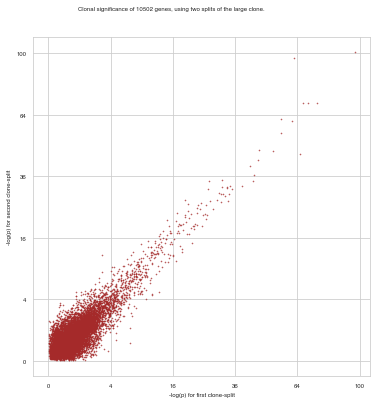

In [36]:
fig,ax = plt.subplots(figsize=(6,6))

sns.scatterplot(x='A1', y='A2', data=np.sqrt(-np.log10(Fp.drop('gene_name',axis=1))), 
                alpha=0.75, edgecolor=None, color='brown', s=2.0) # We use a square-root scale on -log_10(p).

ax.set_xlabel('-log(p) for first clone-split')
ax.set_ylabel('-log(p) for second clone-split')

ticks = [0,2,4,6,8,10]
ax.set_xticks(ticks)
ax.set_xticklabels([t*t for t in ticks])
ax.set_yticks(ticks)
ax.set_yticklabels([t*t for t in ticks])
plt.suptitle('Clonal significance of {} genes, using two splits of the large clone.'.format(len(Fp)))
plt.show()

In [37]:
#from matplotlib_venn import venn2, venn3

pcuts = [0.01, 0.0001, 1e-6, 1e-12, 1e-20]
#fig,ax = plt.subplots(1,len(pcuts),figsize=(3*len(pcuts),4))
genes_sig = {}

for j,pcut in enumerate(pcuts):
    #genes_sig_1 = Fp[Fp['A1'] < pcut].index
    #genes_sig_2 = Fp[Fp['A2'] < pcut].index
    genes_sig[j] = Fp_UMI[Fp_UMI < pcut].index #list(set(genes_sig_1) & set(genes_sig_2))
    #v = venn2([set(genes_sig_1), set(genes_sig_2)], set_labels = ('Split 1', 'Split 2'), ax=ax[j])
    #ax[j].set_title('Sig. genes at p<{}'.format(pcut))
    
#plt.show()

In [38]:
for j in range(len(pcuts)):
    print('{} significant genes found at p<{}.  Contained in genes_sig[{}]'.format(len(genes_sig[j]), pcuts[j],j))

1710 significant genes found at p<0.01.  Contained in genes_sig[0]
715 significant genes found at p<0.0001.  Contained in genes_sig[1]
425 significant genes found at p<1e-06.  Contained in genes_sig[2]
169 significant genes found at p<1e-12.  Contained in genes_sig[3]
88 significant genes found at p<1e-20.  Contained in genes_sig[4]


# Subclone identification

We look at the clusters obtained by looking only at the genes meeting the p<0.001 threshold.

In [39]:
ad_ue = adata['umiexon'][:,genes_sig[1]].copy()

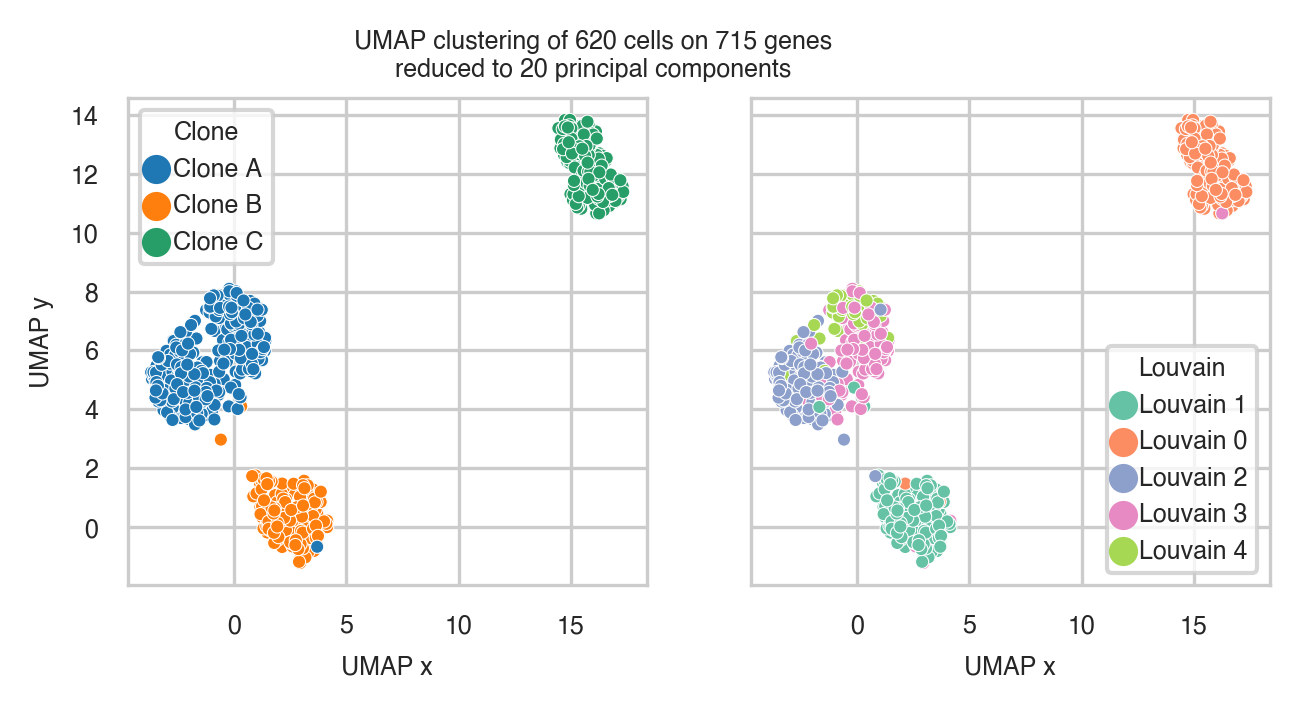

In [40]:
n_components = 20
n_neighbors = 10
min_dist = 0.25

figsize=(110*mm,60*mm)
fig, ax = plt.subplots(1,2, figsize=figsize, dpi=300, sharey=True, sharex=True)
setfontsize()

sc.tl.louvain(ad_ue, resolution=0.9)

X = ad_ue.to_df()
y = ad_ue.obs.clone_id


pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                        metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = ['Clone '+cl[-1] for cl in y.values]
clones = ['Clone A','Clone B','Clone C']

cl_df['Louvain'] = ['Louvain '+lou for lou in ad_ue.obs.louvain.astype(str).values]
g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', hue_order = clones, data = cl_df, s=10, ax=ax[0])

g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Louvain', palette='Set2', data = cl_df, s=10, ax=ax[1])


#if j == 0:
#    g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)

plt.suptitle('UMAP clustering of {} cells on {} genes \n' 
                'reduced to {} principal components \n'.format(X.shape[0], X.shape[1], n_components), y=1.02)

set_size(fig, figsize)
plt.savefig('SuppPanels/UMI_clones_Louvain.pdf', bbox_inches='tight')
plt.show()

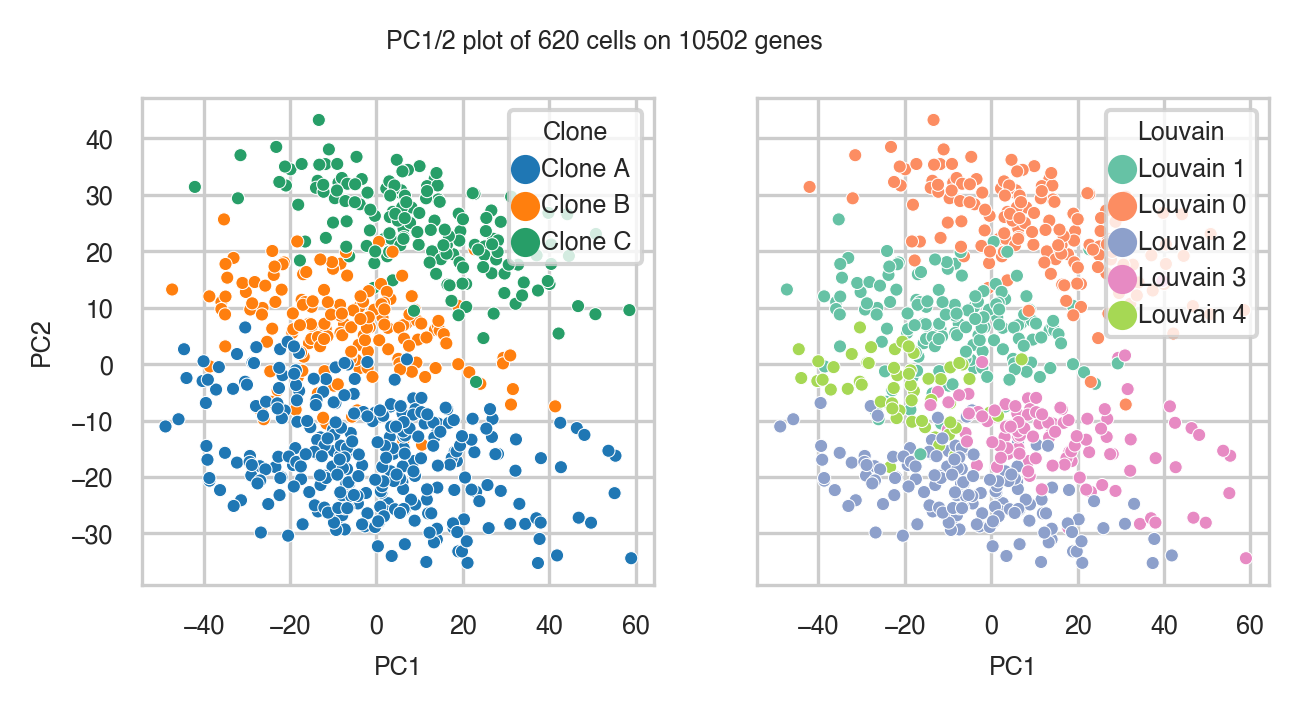

In [41]:

figsize=(110*mm,60*mm)
fig, ax = plt.subplots(1,2, figsize=figsize, dpi=300, sharey=True, sharex=True)
setfontsize()

pca = PCA(n_components=n_components)
X_allgene = adata['umiexon'].to_df().copy()
X_pca = pca.fit_transform(X_allgene) # Apply PCA with 10 components.

cl_df = pd.DataFrame(X_pca[:,:2], columns = ['PC1', 'PC2'], index=X.index) # Just for graphing.
cl_df['Clone'] = ['Clone '+cl[-1] for cl in y.values]
cl_df['Louvain'] = ['Louvain '+lou for lou in ad_ue.obs.louvain.astype(str).values]

clones = ['Clone A','Clone B','Clone C']

g = sns.scatterplot(x='PC1', y='PC2', hue='Clone', hue_order = clones, data = cl_df, s=10, ax=ax[0])

g = sns.scatterplot(x='PC1', y='PC2', hue='Louvain', palette='Set2', data = cl_df, s=10, ax=ax[1])


#if j == 0:
#    g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)

plt.suptitle('PC1/2 plot of {} cells on {} genes'.format(X_allgene.shape[0], X_allgene.shape[1]), y=1.02)

set_size(fig, figsize)
plt.savefig('SuppPanels/UMI_clones_PCA.pdf', bbox_inches='tight')
plt.show()

In [ ]:
PC_loads = pd.DataFrame(index=X_allgene.columns)
PC_loads['PC1'] = pca.components_[0]
PC_loads['PC2'] = pca.components_[1]
PC_loads = PC_loads.sort_values('PC1')

In [ ]:
def load_plot(PC_loads, num=20):
    PCs = PC_loads.columns
    fig,ax = plt.subplots(len(PCs), 1, figsize=(80*mm, 40*len(PCs)*mm), dpi=300,
                         gridspec_kw={'hspace':0.6})
    sns.set_style('whitegrid')
    setfontsize()
    
    for j,col in enumerate(PC_loads.columns):
        PCload = PC_loads[col].sort_values()
        PCload = PCload.iloc[list(range(10)) + list(range(-10,0))]
        plot_df = pd.DataFrame(PCload)
        plot_df['gene'] = plot_df.index
        plot_df['pos'] = plot_df[col] > 0
        ax[j].tick_params(axis='x',rotation=90, pad=-1)
        ax[j].tick_params(axis='y', pad=-1)
        sns.scatterplot(x='gene', y=col, hue='pos', data=plot_df, legend=False, s=15, ax=ax[j])
    
    plt.show()
        

In [ ]:
load_plot(PC_loads)

Let's look at Clone A a bit more closely, separating the two clumps we see in the UMAP plot.

In [ ]:
ad_A = ad_ue[ad_ue.obs.clone_id == 'Clone_A', :]
ad_A.obs.louvain.value_counts()

We create a new clone label, containing an extra mark for Louvain clusters 2 and 3 within Clone A.

In [ ]:
ad_ue.obs['ClonePlus'] = ad_ue.obs['clone_id'].astype(str).copy()
for cell in ad_ue.obs.index:
    if ad_ue.obs.loc[cell, 'clone_id'] == 'Clone_A':
        if ad_ue.obs.loc[cell, 'louvain'] == '2':
            ad_ue.obs.loc[cell, 'ClonePlus'] = 'A-1'
        elif ad_ue.obs.loc[cell, 'louvain'] in ['3','4']:
            ad_ue.obs.loc[cell, 'ClonePlus'] = 'A-2'
        else:
            ad_ue.obs.loc[cell, 'ClonePlus'] = 'A'
    elif ad_ue.obs.loc[cell, 'clone_id'] == 'Clone_B':
        ad_ue.obs.loc[cell, 'ClonePlus'] = 'B'
    elif ad_ue.obs.loc[cell, 'clone_id'] == 'Clone_C':
        ad_ue.obs.loc[cell, 'ClonePlus'] = 'C'
    

ad_ue = ad_ue[ad_ue.obs.ClonePlus != 'A', :] # Delete Clone_A not in two big Louvain clusters.
ad_ue.obs.ClonePlus.value_counts()

Here's a somewhat generic function for heatmaps of gene expression.

In [ ]:
clones = ['Clone_A', 'Clone_B', 'Clone_C']
clonesplus = ['A-1','A-2','B','C']
clonesA = ['A-1','A-2']

In [ ]:
def darken(rgb):
    r,g,b = rgb
    rgb_dark = (0.5*r, 0.5*g, 0.5*b)
    return rgb_dark

def lighten(rgb):
    r,g,b = rgb
    rgb_dark = (0.5*r + 0.5, 0.5*g + 0.5, 0.5*b + 0.5)
    return rgb_dark

pal = sns.color_palette()
lut = dict(zip(clones, pal))

cp_lut = {}
cp_lut['A-1'] = darken(lut['Clone_A'])
cp_lut['A-2'] = lighten(lut['Clone_A'])
cp_lut['B'] = lut['Clone_B']
cp_lut['C'] = lut['Clone_C']
cp_lut

In [ ]:
def miniheat(ef, mf, genelist, prop='clone_id', classlist = clones, lut=None, filename=None, hpush = 0,
            show_genes=False, figsize=None):
    '''
    Visualizes gene expression across cells.
    
    Args:
        ef (pandas dataframe):  The gene expression matrix.
        mf (pandas dataframe:  The metadata dataframe.
        genelist (list): The list of genes to visualize.
        prop:  A column of the metadata, e.g. Clone_ID.  Place cells in blocks according to this.
        classlist:  Custom sort Clone_ID (or whatever prop) according to this list.
        filename:  If given, the filename to save the figure, e.g. 'heatmap.pdf'
        
    Returns:
        None.  Just makes a pretty picture.
        
    
    '''
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    
    #genelist = gene_names[genelist] # Human-readable names.
    #df.columns = genelist
    
    df[prop] = mf
    df_cl = df.groupby(prop).mean()
    df = df.sort_values(prop)
    
    # Sort genes by markers of clones.
    marker_list = []
    df_cl = df.groupby(prop).mean()
    for cl in df[prop].unique():
        markers = [gene for gene in genelist if df_cl[gene].max() == df_cl[gene][cl]]
        marker_list += markers
    genelist = marker_list
    
    # Final dataframe and metadata for plot.
    df = df[genelist]
    md = mf.loc[df.index]

    # Create plot.
    
    # Set (small) figure size and fonts
    if figsize:
        figsize = figsize
    else:
        if show_genes:
            figheight = (2.6*len(genelist) + 15)*mm
        else:
            figheight = 60*mm
        figsize = (50*mm, figheight)
    f, ax = plt.subplots(2,1,figsize=figsize, dpi=300,
                        gridspec_kw={'height_ratios':[1,30],
                                    'hspace':0.01},
                        sharex=True)
    
    sns.set_style("white")
    setfontsize()
    
    # Create colors for clones (or whatever classes)
    if lut:
        0==0
    else:
        pal = sns.color_palette()
        lut = dict(zip(classlist, pal))
    colors = md.astype(str).map(lut)
    colors.name = prop
    
    df_z = df[genelist]
    df_z = (df_z - df_z.mean()) / df_z.std()
    
    sns.heatmap(df_z.T, cmap="coolwarm", vmin=-2, vmax=2, ax=ax[1], cbar=False, yticklabels=True)
    
    ax[1].set_xticklabels([])
    if show_genes == False:
        ax[1].set_yticklabels([])
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')
    ax[1].tick_params(axis='y', pad=-1)
    clone_pops = md.value_counts()
    x_cl = 0
    for cl in classlist:
        cl_pop = clone_pops[cl]
        ax[0].add_patch(plt.Rectangle((x_cl,0), cl_pop, 1, color=lut[cl], alpha=0.5))
        ax[0].text(x_cl + 0.5*cl_pop, 0.5, cl, ha='center', va='center')
        x_cl += cl_pop
        
    ax[0].set_yticklabels([])
    #ax[0].set_title('Clone ID',y=0.95)
    [s.set_visible(False) for s in ax[0].spines.values()]
    
    # plt.suptitle('{} clonal genes, {} groups'.format(len(genelist),len(classlist)), x=0.55, y=0.95)
    set_size(f, figsize)
    if filename:
        plt.savefig('SuppPanels/{}'.format(filename), bbox_inches='tight')
    else:
        plt.savefig('SuppPanels/Heatmap.pdf', bbox_inches='tight')
    
    plt.show()

In [ ]:
X = ad_ue.to_df()
y = ad_ue.obs.ClonePlus

In [ ]:
miniheat(X,y,genes_sig[2], prop='ClonePlus', lut=cp_lut, classlist=clonesplus, filename='Heatmap_3clones.pdf',
        figsize=(45*mm, 140*mm))

In [ ]:
ad_A = ad_ue[ad_ue.obs.clone_id == 'Clone_A', :]
ad_A.obs.ClonePlus.value_counts()

In [ ]:
X_A = ad_A.to_df()
y_A = ad_A.obs.ClonePlus

In [ ]:
A12_p = ANOVA_p(X_A[genes_sig[2]],y_A).sort_values()
A12_p.head()

In [ ]:
A12_markers = [gene for gene in genes_sig[2] if X[gene].groupby(y).mean().idxmax() in ['A-1','A-2']]
len(A12_markers)

In [ ]:
B_markers = [gene for gene in genes_sig[2] if X[gene].groupby(y).mean().idxmax() == 'B']
len(B_markers)

In [ ]:
C_markers = [gene for gene in genes_sig[2] if X[gene].groupby(y).mean().idxmax() == 'C']
len(C_markers)

In [ ]:
print('Genes which are markers for B:')
print(', '.join(B_markers))
print('='*70)
print('Genes which are markers for C:')
print(', '.join(C_markers))

In [ ]:
A12_markers_sep = [gene for gene in A12_markers if A12_p[gene] < 0.01]
len(A12_markers_sep)

In [ ]:
A12_markers_tog = [gene for gene in A12_markers if gene not in A12_markers_sep]
len(A12_markers_tog)

In [ ]:
A12_markers_sep.sort()
A12_markers_tog.sort()

In [ ]:
print('Genes which separate A1 from A2:')
print(', '.join(A12_markers_sep))
print('='*70)
print('Genes which are similar in A1 and A2, but separate A from B and C:')
print(', '.join(A12_markers_tog))

In [ ]:
miniheat(X_A,y_A,A12_markers_sep, prop='ClonePlus', classlist=['A-1','A-2'], lut=cp_lut, show_genes=True,
        filename='Heatmap_subclones_sep.pdf', figsize=(45*mm, 140*mm))

In [ ]:
miniheat(X_A,y_A,A12_markers_tog, prop='ClonePlus', classlist=['A-1','A-2'], lut=cp_lut, show_genes=True,
        filename='Heatmap_subclones_tog.pdf', figsize=(45*mm, 140*mm))

In [ ]:
Ap = ANOVA_p(X_A,y_A).sort_values()
Ap.head()

# Panel:  UMAP Clustering, with subclones colored

In [ ]:
n_components = 20
n_neighbors = 10
min_dist = 0.25

figsize=(50*mm,60*mm)
fig, ax = plt.subplots(1,1, figsize=figsize, dpi=300)
setfontsize()

sc.tl.louvain(ad_ue, resolution=1.0)

X = ad_ue.to_df()
y = ad_ue.obs.ClonePlus


pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                        metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone-subcluster'] = y.values
cl_df = cl_df.sort_values('Clone-subcluster')

g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone-subcluster', palette=cp_lut, data = cl_df, s=8, ax=ax)

ax.set_xticks([])
ax.set_yticks([])
plt.suptitle('UMAP clustering of {} cells on {} genes \n' 
                'reduced to {} principal components \n'.format(X.shape[0], X.shape[1], n_components), y=1.02)

set_size(fig, figsize)
plt.savefig('SuppPanels/UMI_clones_plus.pdf', bbox_inches='tight')
plt.show()

# Cell size correlations

Now we look for any correlations that might exist between cell size (quantified by FCS and SSC) and gene expression in our normalized UMI matrix.  We restrict to the UMI matrix from exons only here.

In [70]:
X = adata['umiexon'].to_df()
X.shape

(620, 10502)

We look closely at those genes which are "always on" in the following sense:  99% of cells have expression level above 2, in the log-normalized UMI counts.

In [71]:
X_almostmin = X.quantile(0.01)
on_genes = X_almostmin[X_almostmin > 2].index
len(on_genes)

184

Here is a list of the on-genes.  It's dominated by RPS/RPL genes, MT-genes, with some others like B2M and MALAT1 mixed in.

In [72]:
print(', '.join(on_genes))

MTND2P28, hsa-mir-6723, ENO1, CDC42, RPL11, SH3BGRL3, CD52, LAPTM5, LCK, RPS8, RPL5, CD2, RPS27, PTPRC, H3F3A, PIP4K2A, PRF1, RPS24, RPLP2, LSP1, RPL27A, RPS13, EEF1G, RARRES3, FAU, NEAT1, MALAT1, CFL1, CTSW, PTPRCAP, RPS3, CD3E, CD3D, CD3G, ATP5L, RPS25, HSPA8, GAPDH, CLEC2D, KLRC4-KLRK1, ARHGDIB, PFDN5, RP11-968A15.8, RPS26, RPL41, MYL6B, MYL6, NACA, RPL6, RPLP0, UBC, RPL21, TPT1, PSME1, RPS29, RPL36AL, SRSF5, CALM1, EVL, B2M, RPL4, RPLP1, UBE2Q2P6, RPS17L, RPS2, IL32, RPS15A, CORO1A, ITGAL, COX4I1, RPL13, PFN1, RP11-849F2.7, RPL23A, CCL5, RPL23, RPL19, RPL27, LIMD2, DDX5, RPL38, H3F3B, ACTG1, MYL12A, RPL17-C18orf32, RPS15, OAZ1, EEF2, RPL36, RPS28, RPL18A, UBA52, HCST, GMFG, RPS16, RPS19, RPL18, RPL13A, RPS11, NKG7, RPS9, RPL28, RPS5, RPS7, ID2, RPS27A, TMSB10, CD8A, RPL31, STK17B, RPL37A, ARPC2, PTMA, RPL41P1, ATP5E, RAC2, DDX17, RPL3, RPL15, RPSA, RPL14, RPL29, RPL24, RPL35A, RPL9, TMSB4XP8, RPL34, RPS3A, RPL37, GZMA, BTF3, RPS23, HINT1, CD74, RPS14, NPM1, HNRNPH1, GNB2L1, HLA-H, 

The FCS and SSC numbers (related to cell size) are contained in the anndata obs frame.

In [73]:
cell_sizes = adata['umiexon'].obs[['FCS','SSC']]
cell_sizes.head()

,FCS,SSC
obs_names,,
P1P2_cell_94,42674.0,21771.0
P1P2_cell_166,40430.0,26377.0
P1P2_cell_286,48814.0,15158.0
P1P2_cell_382,46710.0,19682.0
P1P2_cell_142,41638.0,17796.0


We compute correlations to *all* genes in our expression matrix (UMI exon based).

In [74]:
sizecorr_df = pd.DataFrame(index=X.columns)
sizecorr_df['FCS'] = X.corrwith(cell_sizes['FCS'])
sizecorr_df['SSC'] = X.corrwith(cell_sizes['SSC'])
sizecorr_df.head()

,FCS,SSC
gene_name,,
WASH7P,0.031962,0.074013
AL627309.1,0.006829,0.095920
RP11-34P13.13,0.050963,0.088051
RP4-669L17.10,0.002059,0.068498
MTND1P23,0.027103,0.026979


To look for unusual correlations, we plot a histogram of the Pearson r values for all genes, on a log-scale.  This should look like a log-scaled Beta distribution I think.

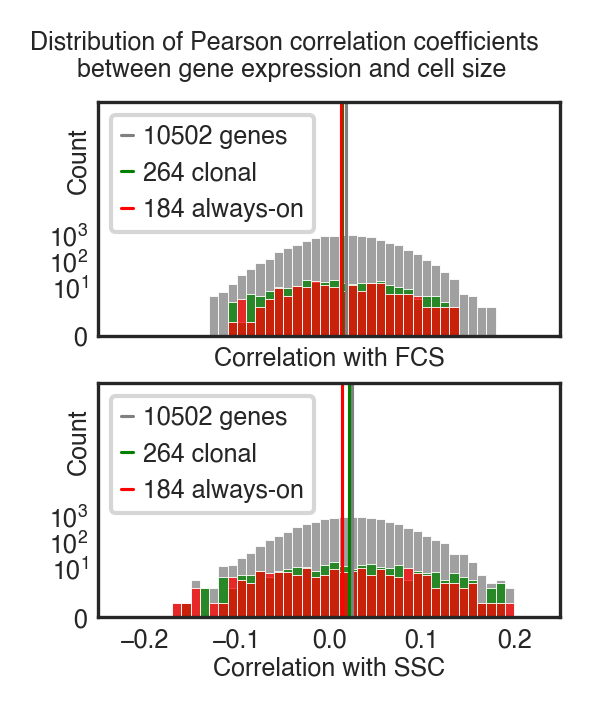

In [75]:
figsize=(50*mm,60*mm)
fig, ax = plt.subplots(2,1, figsize=figsize, dpi=300, sharey=True, sharex=False)
sns.set_style('whitegrid')
setfontsize()

bins = np.arange(-0.25, 0.25, 0.01)
for j,meas in enumerate(['FCS','SSC']):
    data = sizecorr_df[meas]
    sns.histplot(data, kde=False, ax=ax[j], bins=bins, color='gray')
    sns.histplot(data[genes_sig[2]], kde=False, ax=ax[j], bins=bins, color='green')
    sns.histplot(data[on_genes], kde=False, ax=ax[j], bins=bins, color='red')
    
    ax[j].axvline(data.mean(), color='gray', 
                  label='{} genes'.format(len(data)), linewidth=0.75)
    ax[j].axvline(data[genes_sig[2]].mean(), color='green', 
                  label='{} clonal'.format(len(genes_sig[2])), linewidth=0.75)
    ax[j].axvline(data[on_genes].mean(), color='red', 
                  label='{} always-on'.format(len(on_genes)), linewidth=0.75)
    ax[j].set_xlabel('Correlation with {}'.format(meas), labelpad=j)
    ax[j].set_ylabel('Count', y=0.75, labelpad=-10)
    ax[j].legend(loc='upper left')
    ax[j].tick_params(axis='both', pad=-1)
    if j == 0:
        ax[j].set_xticklabels([])

    ax[j].set_xlim(-0.25,0.25)
plt.ylim(0,1e8)

plt.yscale('symlog')
ax[j].set_yticks([0,10,100,1000])
plt.suptitle('Distribution of Pearson correlation coefficients \n between gene expression and cell size', y=1.02)

set_size(fig, figsize)
plt.savefig('SuppPanels/Size_Correlations.pdf', bbox_inches='tight')
plt.show()

There seems to be a slight shift to the right, by about 0.02 (in r-values), on average and at the extremes.

In [76]:
def cell_size_corr(gene):
    sns.set_style('white')
    figsize=(45*mm,35*mm)
    fig, ax = plt.subplots(1,2, figsize=figsize, dpi=300, sharey=True)
    setfontsize()
    sns.regplot(cell_sizes['SSC']/10000, X[gene], ax=ax[0], 
                scatter_kws={'s':1.0, 'color':'steelblue', 'alpha':0.4}, 
                line_kws={'linewidth':1.0, 'color':'darkblue'})
    sns.regplot(cell_sizes['FCS']/10000, X[gene], ax=ax[1], 
                scatter_kws={'s':1.0, 'color':'steelblue', 'alpha':0.4}, 
                line_kws={'linewidth':1.0, 'color':'darkblue'})
    ax[0].set_ylabel(gene)
    ax[1].set_ylabel('')
    ax[0].set_xlabel('SSC (1e4)')
    ax[1].set_xlabel('FCS (1e4)')
    ax[0].tick_params(axis='both', pad=-1)
    ax[1].tick_params(axis='both', pad=-1)
    ax[0].set_title('$R^2 = {:1.3f}$'.format(sizecorr_df.loc[gene,'SSC']**2 ), y=0.95)
    ax[1].set_title('$R^2 = {:1.3f}$'.format(sizecorr_df.loc[gene,'FCS']**2), y=0.95)
    #plt.ylim(X[gene].quantile(0.1),X[gene].quantile(0.9))
    set_size(fig, figsize)
    plt.savefig('SuppPanels/FSC_SSC_corr_{}.pdf'.format(gene), bbox_inches='tight')
    plt.show()

Let's look at a few genes with $r > 0.2$.

In [77]:
sizecorr_df[sizecorr_df['SSC'] > 0.18].index

Index(['FCER1G', 'CCL5', 'NKG7', 'MAL', 'ABHD16A', 'PRKAR1B'], dtype='object', name='gene_name')

In [78]:
sizecorr_df[sizecorr_df['FCS'] > 0.16].index

Index(['MLEC', 'SLC25A30', 'MFF', 'PLSCR1'], dtype='object', name='gene_name')

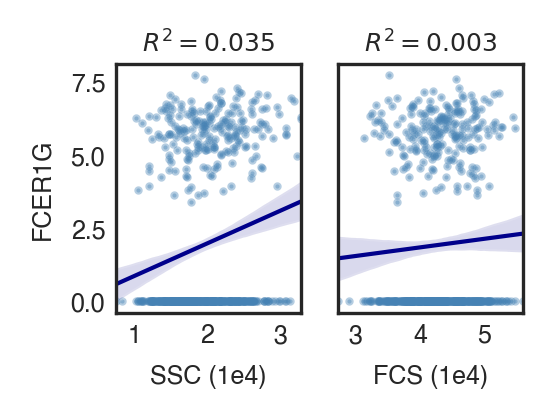

In [79]:
cell_size_corr('FCER1G')

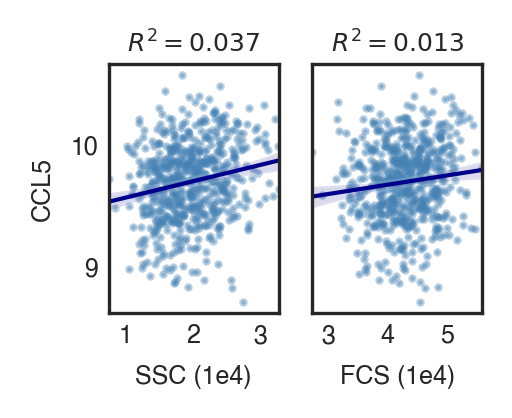

In [80]:
cell_size_corr('CCL5')

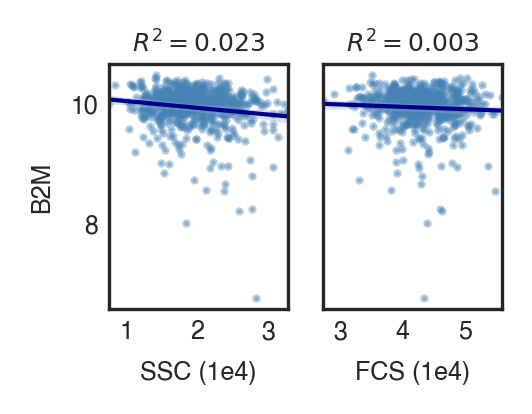

In [81]:
cell_size_corr('B2M')

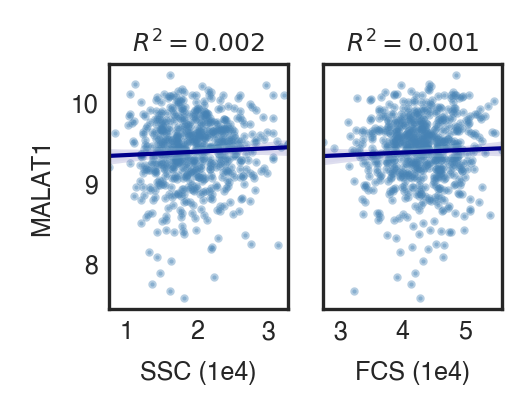

In [82]:
cell_size_corr('MALAT1')